In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
grouped = pd.read_csv('./20220615_total.csv')

In [3]:
meta = pd.read_csv("../tensorMaker/nftMetaData.csv")

In [4]:
import numpy as np
from math import log2
import pandas as pd
import sqlite3

# Create a SQL connection to our SQLite database
con = sqlite3.connect("../DataOtherSources/EthereumNFTs/nfts.sqlite")

cur = con.cursor()
currentOwners = pd.read_sql_query("SELECT * from current_owners", con)
# print(df.head(10))
# Be sure to close the connection
con.close()

groupedOwners = currentOwners.groupby("nft_address")
entropyPandas = []

def entropy(labels):
    #.....................................
    uniqueLabels = np.unique(labels, return_counts=True)
    totalSumProbabilities = 0
    listLength = len(labels)
    for variableCount in uniqueLabels[1]:
        label_Probability = variableCount / (listLength)
        label_Entropy = label_Probability * log2(label_Probability)
        totalSumProbabilities += label_Entropy
    # print(-totalSumProbabilities)
    return -totalSumProbabilities


for (nftName, groupobject) in groupedOwners.__iter__():
        entropyScore = entropy(groupobject["owner"])
        entropyPandas.append({
            "nft":nftName.lower(),
            "entropyScore":entropyScore
        })

In [5]:
entropyPandas = pd.DataFrame(entropyPandas)

In [6]:
entropyPandasFilterd = entropyPandas[entropyPandas["entropyScore"] >1]

In [7]:
entropyPandasFilterd.sort_values(by="entropyScore")

,nft,entropyScore
5710,0x9fcdd59cec1ea5b31c55a13eb0f8d2038eaac264,1.003267
6223,0xbc3d85bdb57a8ecb1ef79c40552ad04e7285026e,1.008064
4567,0x814e0e378fff8ed861418f8f31c59dd740c8ce01,1.010390
4581,0x81962829804d584ff37fe3f561bed8f39923cf38,1.014098
886,0x18ad63858b9f7fdb7903d803fea2a25fe760177c,1.014404
...,...,...
2987,0x5537d90a4a2dc9d9b37bab49b490cf67d4c54e91,13.285761
7768,0xabc207502ea88d9bca29b95cd2eee5f0d7936418,13.714889
6369,0xc36442b4a4522e871399cd717abdd847ab11fe88,13.742724
3428,0x60f80121c31a0d46b5279700f9df786054aa5ee5,13.831032


In [8]:
grouped['timeStamp'] = pd.to_datetime(grouped['timeStamp'], utc=True)
grouped["timeStamp-day"] = grouped['timeStamp'].dt.floor('D')
grouped["nft_address"] = grouped["nft_address"].str.lower()

In [9]:
from scipy.stats import kurtosis
pivot_trades = pd.pivot_table(grouped, values="quant", index="timeStamp-day", columns="nft_address", aggfunc=np.sum)
pivot_mean_log = pd.pivot_table(grouped, values="priceInDollarLog", index="timeStamp-day", columns="nft_address", aggfunc=np.mean)
# pivot_mean_ETH = pd.pivot_table(grouped, values="transactionEther_average", index="timeStamp-day", columns="nft_address", aggfunc=np.mean)
pivot_max_log = pd.pivot_table(grouped, values="priceInDollarLog", index="timeStamp-day", columns="nft_address", aggfunc=np.max)
pivot_change_in_trades = pd.pivot_table(grouped, values="quant", index="timeStamp-day", columns="nft_address", aggfunc=np.sum).rolling(window=2).apply(lambda x: x.iloc[1] - x.iloc[0])
pivot_change_in_log_prices = pd.pivot_table(grouped, values="priceInDollarLog", index="timeStamp-day", columns="nft_address", aggfunc=np.mean).rolling(window=2).apply(lambda x: x.iloc[1] - x.iloc[0])
pivot_kurt_log = pd.pivot_table(grouped, values="priceInDollarLog", index="timeStamp-day", columns="nft_address", aggfunc=kurtosis)

In [10]:
tensor = np.array([
    pivot_trades,
    pivot_max_log,
    pivot_change_in_trades,
    pivot_change_in_log_prices,
    pivot_kurt_log,
    pivot_mean_log,
    # pivot_mean_ETH
])

In [90]:
import numpy as np
import pandas as pd
from scipy.stats import kurtosis
clusterDataList = []
errorList = []
for series in range(tensor.shape[2]):
    clusterData = {}
    
    data = tensor[:,:, series]

    clusterData['nft']=pivot_trades.iloc[:,series].name
    clusterData['Length']=len(data[0,:][~np.isnan(data[0,:])])

    clusterData['changeSquared_trade']=np.mean(np.power(data[2,:][~np.isnan(data[2,:])],2))
    
    clusterData['changeSquared_price']=np.mean(np.power(data[3,:][~np.isnan(data[3,:])],2))
    clusterData['changeCube_price']=np.mean(np.power(data[3,:][~np.isnan(data[3,:])],3))

    for statisticsSeries in range(tensor.shape[0]):
        try:
            clusterData[statisticsSeries,'average'] =np.average(data[statisticsSeries,:][~np.isnan(data[statisticsSeries,:])])
            clusterData[statisticsSeries,'median'] =np.nanmedian(data[statisticsSeries,:])
            clusterData[statisticsSeries,'var'] =np.nanvar(data[statisticsSeries,:])
            clusterData[statisticsSeries,'mean'] = np.nanmean(data[statisticsSeries,:])
            clusterData[statisticsSeries,'std'] =np.nanstd(data[statisticsSeries,:])
            clusterData[statisticsSeries,'max'] =np.max(data[statisticsSeries,:][~np.isnan(data[statisticsSeries,:])])
            clusterData[statisticsSeries,'min'] =np.min(data[statisticsSeries,:][~np.isnan(data[statisticsSeries,:])])
            clusterData[statisticsSeries,'sum'] =np.sum(data[statisticsSeries,:][~np.isnan(data[statisticsSeries,:])])
            clusterData[statisticsSeries,'kurtosis'] = kurtosis(data[statisticsSeries,:][~np.isnan(data[statisticsSeries,:])])
            clusterDataList.append(clusterData)
        except Exception:
            continue
            # errorData = {}
            # errorData["Err"] = data[statisticsSeries,:][~np.isnan(data[statisticsSeries,:])]
            # errorList.append(errorData)
            
    
err = pd.DataFrame(errorList)
x = pd.DataFrame(clusterDataList)

c:\Users\Thoma\.conda\envs\nftProject\lib\site-packages\numpy\core\fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\Thoma\.conda\envs\nftProject\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\Users\Thoma\.conda\envs\nftProject\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
c:\Users\Thoma\.conda\envs\nftProject\lib\site-packages\numpy\lib\nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
<ipython-input-90-3682be0fe87c>:23: RuntimeWarning: Degrees of freedom <= 0 for slice.
  clusterData[statisticsSeries,'var'] =np.nanvar(data[statisticsSeries,:])
<ipython-input-90-3682be0fe87c>:24: RuntimeWarning: Mean of empty slice
  clusterData[statisticsSeries,'mean'] = np.nanmean(data[stat

In [91]:
X_dropped=x.drop_duplicates()

In [92]:
X_dropped = X_dropped.dropna(axis=0, how='any')

In [93]:
X_dropped =pd.merge(X_dropped, meta, on="nft")

In [94]:
X_labels = pd.DataFrame(X_dropped.iloc[:,1])

In [95]:
X_dropped.iloc[1:3,36]

1   -3.000000
2   -0.432875
Name: (4, mean), dtype: float64

In [96]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

X = X_dropped.iloc[:,1:]
X_std = StandardScaler().fit_transform(X)

pca = PCA()
principalComponents = pca.fit_transform(X_std)

features = range(pca.n_components_)

PCA_components = pd.DataFrame(principalComponents)

In [97]:
tSNE = TSNE(n_components=3)
tSNE_COMPS = tSNE.fit_transform(PCA_components)
tSNE_PCA_components = pd.DataFrame(tSNE_COMPS)

In [100]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import mixture

nComponents = 21
features = 5
gmm = mixture.GaussianMixture(
    n_components=nComponents
)

gmm_labels = gmm.fit_predict(PCA_components.iloc[:,:5])
X_dropped["labels-kmeans-tSNEPCA-"+str(nComponents)+"-"+str(features)] = gmm_labels
X_labels["labels-kmeans-tSNEPCA-"+str(nComponents)+"-"+str(features)] = gmm_labels

In [101]:

from sklearn.cluster import AgglomerativeClustering

clustering = AgglomerativeClustering(linkage="ward", n_clusters=3)
labelsAgglotSNEPCA = clustering.fit_predict(PCA_components.iloc[:,:5])

X_dropped["labels-Agglo-tSNEPCA-3"] = labelsAgglotSNEPCA
X_labels["labels-Agglo-tSNEPCA-3"] = labelsAgglotSNEPCA

In [102]:
from sklearn.cluster import KMeans
kmeanstPCA = KMeans(n_clusters=4)
labels = kmeanstPCA.fit_predict(PCA_components.iloc[:,:5])
X_dropped["labels-kmeans-tSNEPCA-5-4"] = labels
X_labels["labels-kmeans-tSNEPCA-5-4"] = labels

In [103]:
nftAddressNames = pd.read_csv("../webscraper/nftNames-baseline.csv")
nftNames = dict(zip(nftAddressNames["addressBaselined"], nftAddressNames["name"]))
nftSymbol = dict(zip(nftAddressNames["addressBaselined"], nftAddressNames["symbol"]))


In [104]:
X_dropped =pd.merge(X_dropped, entropyPandas, on="nft")

In [105]:
X_dropped["name"] = X_dropped["nft"].replace(nftNames)
X_dropped["symbol"] = X_dropped["nft"].replace(nftSymbol)

In [51]:
X_dropped.iloc[:,37]

0       2.374025
1       0.000000
2       3.625094
3       4.252759
4       0.000000
          ...   
3727    0.711633
3728    0.881177
3729    0.894835
3730    1.045175
3731    0.000000
Name: (4, std), Length: 3732, dtype: float64

In [106]:
smallerDataset = X_dropped.iloc[:,-6:]
smallerDataset["tradeMean"] = X_dropped.iloc[:,9]
smallerDataset["PriceVolatility"] = X_dropped.iloc[:,37]
smallerDataset.sort_values(by="entropyScore", ascending=False).to_csv("smallDataSet.csv", index=False)

In [27]:
import numpy as np
import sklearn.metrics as skMetrics
labels = X_labels.iloc[:,1:]
comparison = labels.shape[1]
comp_square = np.zeros((comparison,comparison))

for x in range(comparison):
    for y in range(comparison):
        comp_square[x][y] = skMetrics.adjusted_rand_score(labels.iloc[:,x], labels.iloc[:,y])

np.savetxt("modelComp-SMAL.csv", comp_square, delimiter=",")

PermissionError: [Errno 13] Permission denied: 'modelComp-SMAL.csv'

In [ ]:
np.savetxt("labels-small.csv",np.array(labels.columns), delimiter=",", fmt='%s')

In [ ]:
X_dropped.to_csv("total_with_labels-SMALL.csv")

In [28]:
X_dropped[X_dropped["labels-Agglo-tSNEPCA-3"] == 1].iloc[:,7]

3         4262.370370
6        70743.858325
8           92.793388
10       21792.060357
13           1.918367
            ...      
3685     37922.482449
3689     27198.368848
3715        62.222222
3722    322627.547666
3725    153303.123264
Name: (0, var), Length: 863, dtype: float64

In [29]:
X_labels.iloc[:,1:].columns

Index(['labels-kmeans-tSNEPCA-21-5', 'labels-Agglo-tSNEPCA-3',
       'labels-kmeans-tSNEPCA-5-4'],
      dtype='object')

In [30]:
array = []

for clusterModel in X_labels.iloc[:,1:].columns:
    clusters = len(np.unique(X_dropped[clusterModel]))
    array.append([np.std(X_dropped[X_dropped[clusterModel] == i].iloc[:,7]) for i in range(clusters)])


In [58]:
# np.savetxt("std.csv", np.array(array), delimiter=",", fmt='%s')
smallerDataset.head(1)

,labels-kmeans-tSNEPCA-21-5,labels-Agglo-tSNEPCA-3,labels-kmeans-tSNEPCA-5-4,entropyScore,name,symbol,tradeMean,PriceVolatility
0,3,0,3,2.104002,0x000000000437b3cce2530936156388bff5578fc3,0x000000000437b3cce2530936156388bff5578fc3,2.768087,2.374025


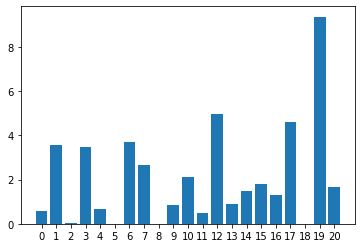

In [63]:
# the histogram of the data



clusters = len(np.unique(smallerDataset["labels-kmeans-tSNEPCA-21-5"]))
bars = [np.mean(smallerDataset[smallerDataset["labels-kmeans-tSNEPCA-21-5"] == i]["PriceVolatility"]) for i in range(clusters)]
plt.bar(range(clusters),bars)
plt.xticks(range(clusters))
plt.show()

In [ ]:
X_dropped.iloc[:,8]

In [66]:
X_dropped

'labels-Agglo-tSNEPCA-3'

In [107]:
setToCompare = "labels-kmeans-tSNEPCA-21-5"
catGroupList = X_dropped.groupby(setToCompare)["entropyScore"].apply(list)
catGroupList

labels-kmeans-tSNEPCA-21-5
0     [7.94462362665938, 9.597781394381062, 7.594602...
1     [2.321928094887362, 1.438826429298142, 2.0, 0....
2                                  [11.401060249451048]
3     [6.455976613609663, 9.340784296977835, 9.44041...
5               [11.445643336483611, 7.561109816385041]
6                                  [1.3709505944546687]
7     [4.591814023625385, 2.0253580033071588, 6.0430...
8              [4.8173873483184195, 13.864018856120808]
9     [10.026307679082072, 5.198498507385562, 12.318...
10    [4.17699200758583, 5.242636215414737, 3.916379...
11    [1.5219280948873621, 6.146702720504815, 0.9182...
12    [1.4256051990169436, 6.418919487288085, 6.4038...
13                                  [11.42026253295887]
14    [7.021417634571415, 4.830585639429564, 8.58073...
15                                 [12.407356898003787]
16    [9.818632506599934, 11.092982322965328, 11.866...
17    [4.053788915271567, 8.029957146190451, 8.42723...
18    [2.104001919975

In [39]:
X_dropped.head(1)

,nft,Length,changeSquared_trade,changeSquared_price,changeCube_price,"(0, average)","(0, median)","(0, var)","(0, mean)","(0, std)",...,uniqueMints,stdTransactionsPerToken,meanTransactionsPerToken,varTransactionsPerToken,labels-kmeans-tSNEPCA-21-5,labels-Agglo-tSNEPCA-3,labels-kmeans-tSNEPCA-5-4,entropyScore,name,symbol
0,0x000000000437b3cce2530936156388bff5578fc3,29,5.571429,1.905449,-0.222952,2.689655,1.0,7.662307,2.689655,2.768087,...,0,1.015819,1.322034,1.031887,3,0,3,2.104002,0x000000000437b3cce2530936156388bff5578fc3,0x000000000437b3cce2530936156388bff5578fc3


In [67]:
smallerDataset.head(1)

,labels-kmeans-tSNEPCA-21-5,labels-Agglo-tSNEPCA-3,labels-kmeans-tSNEPCA-5-4,entropyScore,name,symbol,tradeMean,PriceVolatility
0,3,0,3,2.104002,0x000000000437b3cce2530936156388bff5578fc3,0x000000000437b3cce2530936156388bff5578fc3,2.768087,2.374025


In [121]:
compareTest = "entropyScore"

catGroupList = smallerDataset.groupby("labels-kmeans-tSNEPCA-21-5")[compareTest].apply(list)
print(f_oneway(*catGroupList)[0],f_oneway(*catGroupList)[1])

catGroupList = smallerDataset.groupby("labels-Agglo-tSNEPCA-3")[compareTest].apply(list)
print(f_oneway(*catGroupList)[0],f_oneway(*catGroupList)[1])

catGroupList = smallerDataset.groupby("labels-kmeans-tSNEPCA-5-4")[compareTest].apply(list)
print(f_oneway(*catGroupList)[0],f_oneway(*catGroupList)[1])

199.3740262821236 0.0
174.8395180605868 2.6322904959169814e-73
588.6347762762977 3.42201870143e-313


In [128]:
import scipy.stats as scStat
from scipy.stats import f_oneway,normaltest,bartlett,normaltest


setToCompare = ["labels-kmeans-tSNEPCA-21-5","labels-Agglo-tSNEPCA-3","labels-kmeans-tSNEPCA-5-4"]
compareTest = ["tradeMean","PriceVolatility","entropyScore"]

outcome = []

for set in setToCompare:
    for test in compareTest:

        clusters = len(smallerDataset[set].unique())
        # catGroupList = smallerDataset.groupby(setToCompare)[test].apply(list)

        # print(catGroupList)
        # print(test)
        # print(set)
        # print(f_oneway(*catGroupList))
        # print(bartlett(*catGroupList))
        for i in range(clusters):
                for z in range(clusters):
                    if i != z: 
                        try:
                            if scStat.ttest_ind(smallerDataset[smallerDataset[set]==i][test],smallerDataset[smallerDataset[set]==z][test])[1] > 0.05 :
                                outcome.append({
                                    "test":test,
                                    "set": set,
                                    "z": z,
                                    "i":i
                                })
                        except:
                            continue
            # print(normaltest(smallerDataset[smallerDataset[set] == i][test])[1])
pd.DataFrame(outcome).to_csv("outcomeFtest.csv")
# pd.DataFrame(outcome)


c:\Users\Thoma\.conda\envs\nftProject\lib\site-packages\numpy\core\fromnumeric.py:3621: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\Thoma\.conda\envs\nftProject\lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\Users\Thoma\.conda\envs\nftProject\lib\site-packages\numpy\core\fromnumeric.py:3621: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\Thoma\.conda\envs\nftProject\lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\Users\Thoma\.conda\envs\nftProject\lib\site-packages\numpy\core\fromnumeric.py:3621: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\Thoma

In [38]:
from scipy.stats import f_oneway,normaltest,bartlett

setToCompare = "labels-kmeans-tSNEPCA-21-5"

catGroupList = X_dropped.groupby(setToCompare)["entropyScore"].apply(list)

for i in range(len(catGroupList)):
    print(normaltest(catGroupList[i])[1])

anovaResult = f_oneway(*catGroupList)

print(anovaResult)
print(bartlett(*catGroupList))

0.0570439661786108
2.252419674884387e-13
0.0013172371977330213
3.868036155753033e-06
0.20592013385976246
0.002301689554083719
2.2294950441547128e-08
0.06397263505153031
0.00017197246970011647
2.793989591305267e-07
5.313195012182459e-06
0.03726970742967628
0.012457587280522871
0.002584950220552778
5.4457767653745926e-05
0.00723967411402131
0.00021289012543608505
9.55293481451456e-26
0.05744929672944579
1.2718397964932282e-07
8.089426642942771e-06
F_onewayResult(statistic=195.03297479322705, pvalue=0.0)
BartlettResult(statistic=173.43049118185485, pvalue=1.8625319879023436e-26)


In [45]:
X_dropped["changeSquared_trade"].values

array([ 5.57142857,  1.        , 36.        , ...,  4.        ,
       59.75      ,  2.5       ])

In [65]:
import scipy.stats as scStat

setToCompare = "labels-Agglo-tSNEPCA-3"
clusters = len(X_dropped[setToCompare].unique())


for i in range(clusters):
    normality_priceStab = scStat.normaltest(X_dropped[X_dropped[setToCompare]==i]["changeSquared_price"])
    print("Normality change price",normality_priceStab)
    print("mean change price",np.mean(X_dropped[X_dropped[setToCompare]==i]["changeSquared_price"]))
    print("")

    normality_changeTrade = scStat.normaltest(X_dropped[X_dropped[setToCompare]==i]["changeSquared_trade"])
    print("Normality changetrade",normality_changeTrade)
    print("")

    normality_meanLogPrice = scStat.normaltest(X_dropped[X_dropped[setToCompare]==i].iloc[:,53])
    print("Normality meanlog price",normality_meanLogPrice)
    print("")


    print("mean change trade",np.mean(X_dropped[X_dropped[setToCompare]==i]["changeSquared_trade"]))
    print("mean quant trade",np.mean(X_dropped[X_dropped[setToCompare]==i].iloc[:,8]))
    print("")

    for z in range(clusters):
        tTest = 0
        if i != z: 
            tTest = scStat.ttest_ind(X_dropped[X_dropped[setToCompare]==i]["changeSquared_price"],X_dropped[X_dropped[setToCompare]==z]["changeSquared_price"])
            print("Compare cluster change price", i, " against:", z, ":", tTest)
            print("")
            tTest = scStat.ttest_ind(X_dropped[X_dropped[setToCompare]==i]["changeSquared_trade"],X_dropped[X_dropped[setToCompare]==z]["changeSquared_trade"])
            print("Compare cluster change in trade", i, " against:", z, ":", tTest)
            print("")
            # tTest = scStat.ttest_ind(X_dropped[X_dropped[setToCompare]==i].iloc[:,8],X_dropped[X_dropped[setToCompare]==z].iloc[:,8])
            # print("Compare cluster quantity trade", i, " against:", z, ":", tTest)
            # print("")
            # tTest = scStat.ttest_ind(X_dropped[X_dropped[setToCompare]==i].iloc[:,53],X_dropped[X_dropped[setToCompare]==z].iloc[:,53])
            # print("Compare cluster mean log price", i, " against:", z, ":", tTest)
            # print("")
    print("")
    print("")
    print("")
    print("")

Normality change price NormaltestResult(statistic=6742.666110282033, pvalue=0.0)
mean change price 1.4629628278176543

Normality changetrade NormaltestResult(statistic=4046.151979184674, pvalue=0.0)

Normality meanlog price NormaltestResult(statistic=3252.2863714295563, pvalue=0.0)

mean change trade 652.566458449214
mean quant trade 5.871884461082731

Compare cluster change price 0  against: 1 : Ttest_indResult(statistic=6.333176909080032, pvalue=2.7292428213036796e-10)

Compare cluster change in trade 0  against: 1 : Ttest_indResult(statistic=-10.712735506406556, pvalue=2.4110124587359215e-26)

Compare cluster quantity trade 0  against: 1 : Ttest_indResult(statistic=-30.710210336394688, pvalue=3.179084017686306e-182)

Compare cluster mean log price 0  against: 1 : Ttest_indResult(statistic=20.5758315832395, pvalue=1.438866931634182e-88)

Compare cluster change price 0  against: 2 : Ttest_indResult(statistic=6.4374281382740355, pvalue=1.4194780201264244e-10)

Compare cluster change in